In [1]:
%load_ext autoreload
%matplotlib inline
%config InlineBackend.print_figure_kwargs = {'bbox_inches':None}
import sys
sys.path.insert(1, '../../SyMBac')
sys.path.insert(1, '../../microcolony_analysis_giant_lorentz/')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib import cm
import matplotlib
from matplotlib_scalebar.scalebar import ScaleBar
import tifffile
from skimage.transform import rotate
from skimage.transform import rescale
import scienceplots
from seaborn import move_legend
from copy import deepcopy
plt.style.use('nature')

matplotlib.rcParams["xtick.minor.bottom"]=False
matplotlib.rcParams["xtick.top"]=False
matplotlib.rcParams["ytick.minor.left"]=False
matplotlib.rcParams["ytick.right"]=False
matplotlib.rcParams["font.size"] = 6
#matplotlib.rcParams["axes.labelpad"] = 0
matplotlib.rcParams["axes.spines.right"] = False
matplotlib.rcParams["axes.spines.top"] = False
matplotlib.rcParams["xtick.minor.visible"] = False
matplotlib.rcParams["ytick.minor.visible"] = False
matplotlib.rcParams["xtick.direction"] = "out"
matplotlib.rcParams["ytick.direction"] = "out"
matplotlib.rcParams["legend.fontsize"] = 6
matplotlib.rcParams["svg.fonttype"] = "none"
matplotlib.rcParams["xtick.labelsize"] = 6
matplotlib.rcParams["ytick.labelsize"] = 6
matplotlib.rcParams["axes.titlesize"] = 6
matplotlib.rcParams["axes.labelsize"] = 6
matplotlib.rcParams["grid.alpha"] = 0
matplotlib.rcParams["savefig.transparent"] = True
import pyclesperanto_prototype as cle
from pyclesperanto_prototype import imshow
from matplotlib.colors import LogNorm, AsinhNorm, PowerNorm 
from tqdm.auto import tqdm
from SyMBac.drawing import raster_cell, convert_to_3D
from SyMBac.renderer import convolve_rescale, PSF_generator
import global_params_giant_colony as global_params

In [2]:
def lorentzian_DoG(xdata_tuple, amplitude, xo, gamma, sigma1, sigma2, offset):
    (x, y) = xdata_tuple
    lorentz = offset + amplitude / (1 + ((x - xo) / gamma)**2 + ((y - xo) / gamma)**2)
    gaussian_term_1 = np.exp(-((x - xo)**2 + (y - xo)**2) / (2 * sigma1**2))
    gaussian_term_2 = np.exp(-((x - xo)**2 + (y - xo)**2) / (2 * sigma2**2))
    return (lorentz * (gaussian_term_1 - gaussian_term_2)).ravel()


In [3]:
def calculate_new_offset(old_PSF_size, new_PSF_size, old_offset):
    area_ratio = (new_PSF_size ** 2) / (old_PSF_size ** 2)
    new_offset = old_offset / area_ratio
    return new_offset

In [4]:
from skimage.restoration import richardson_lucy

In [5]:
from cucim.skimage.restoration import richardson_lucy as richardson_lucy_cuda
import cupy as cp

In [ ]:
deconv_img_lorentz = richardson_lucy_cuda(cp.array(conv_colony_3D_rescale_2d), cp.array(lorentz_psf_2D_deconv), 200)

In [ ]:
plt.figure(figsize=(1.5,1.5), dpi = 300)
plt.imshow(deconv_img_lorentz.get(), cmap="turbo")
plt.axis("off")
plt.title("Deconvolved")
plt.savefig("deconvolved.svg")
plt.show()

In [ ]:
from skimage.filters import gaussian
plt.figure(figsize=(1.5,1.5), dpi = 300)
plt.imshow( gaussian(large_colony.sum(axis=0), 1), cmap="turbo")
plt.axis("off")
plt.title("Ground truth")
plt.savefig("ground_truth.svg")
plt.show()

In [6]:
import nd2
from glob import glob

file_names = [
    "100x_SB5_dilute002"
]

nd2_imgs = [glob(f"../../microcolony_analysis/real_data/agar_pads/{file_name}*.nd2") for file_name in file_names]


In [7]:
img = nd2.imread(nd2_imgs[0][0])
import matplotlib.patches as patches

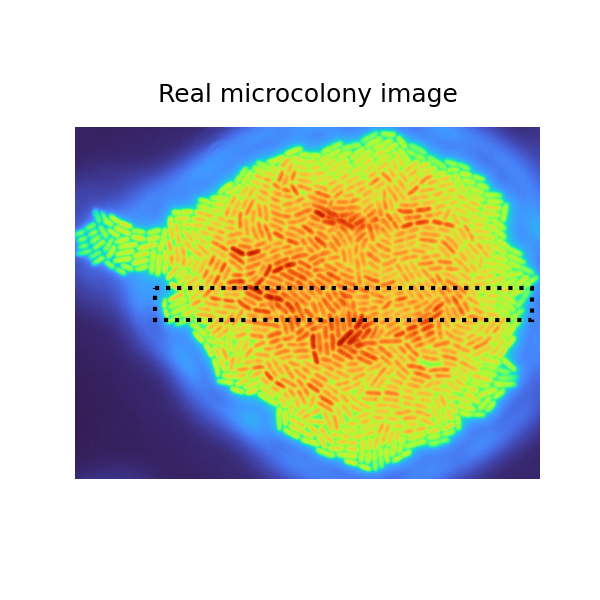

In [8]:
some_img = np.rot90(img[2][1])
some_img = some_img/some_img.sum()
plt.figure(figsize=(2,2), dpi = 300)
plt.imshow(some_img, cmap="turbo")
plt.title("Real microcolony image")
plt.axis("off")
y0, x0 = 1004, 950  # lower left corner
height = 1104 - 1004 
width = 2124 - 950 
plt.xlim(700,2150)
plt.ylim(1600,500)
# Create a rectangle patch with a dotted outline
rect = patches.Rectangle((x0, y0), width, height, linewidth=1, edgecolor='k', facecolor='none', linestyle=':')
plt.gca().add_patch(rect)  # Add the rectangle to the current axes


plt.savefig("real_colony.svg")

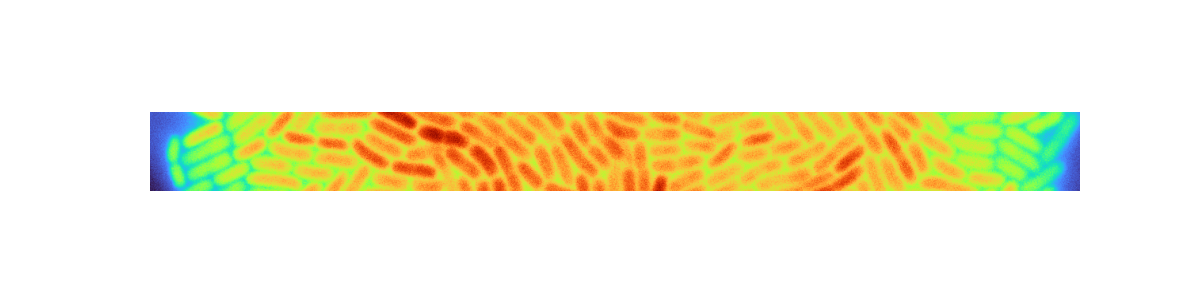

In [9]:
plt.figure(figsize=(4,1), dpi = 300)
plt.axis("off")
real_slice = some_img[1004:1104,950:2124]
plt.imshow(real_slice, cmap="turbo")
plt.savefig("real_colony_slice.svg")

In [10]:
lorentzian_PSF_real_deconv = tifffile.imread("../../cell_distance_bleedthrough/lorentzian_PSF_515nm_2201px.tiff")

deconv_img_lorentz = richardson_lucy_cuda(cp.array(some_img), cp.array(lorentzian_PSF_real_deconv), 500)
deconv_img_lorentz = deconv_img_lorentz.get()

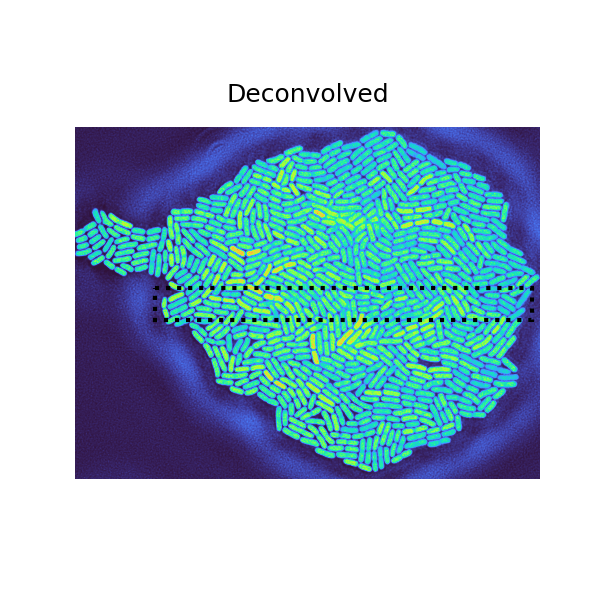

In [11]:
plt.figure(figsize=(2,2), dpi = 300)
plt.imshow(deconv_img_lorentz, cmap="turbo")
plt.title("Deconvolved")
plt.axis("off")
plt.xlim(700,2150)
plt.ylim(500,1600)
rect = patches.Rectangle((x0, y0), width, height, linewidth=1, edgecolor='k', facecolor='none', linestyle=':')
plt.gca().add_patch(rect)  # Add the rectangle to the current axes
plt.xlim(700,2150)
plt.ylim(1600,500)
plt.savefig("real_colony_deconv.svg")

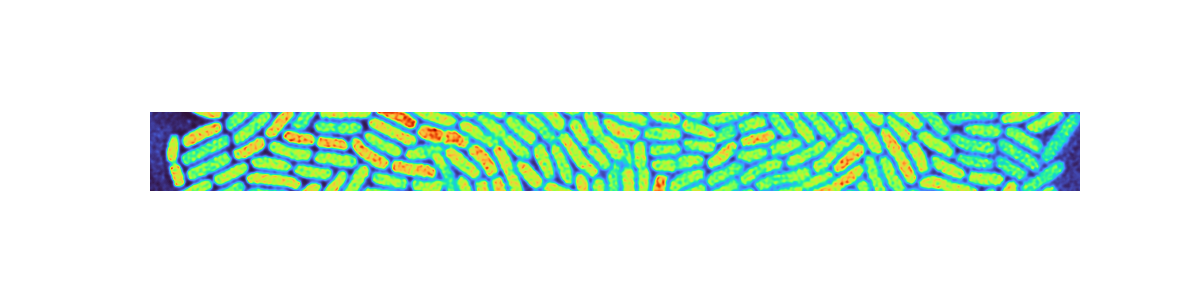

In [12]:
plt.figure(figsize=(4,1), dpi = 300)
plt.axis("off")
real_slice_deconv = deconv_img_lorentz[1004:1104,950:2124]
plt.imshow(real_slice_deconv, cmap="turbo")
plt.savefig("real_colony_slice_deconv.svg")

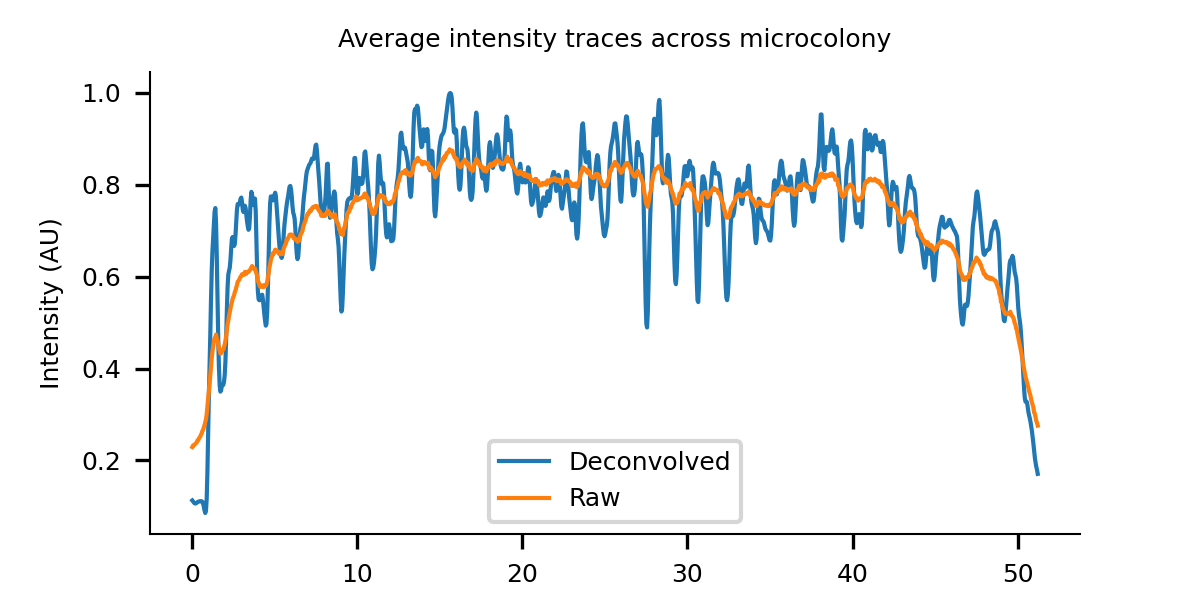

In [13]:
plt.figure(figsize=(4,2), dpi = 300)
xrange = np.arange(real_slice.mean(axis=0).shape[0]) * (0.0655/1.5)
plt.plot(xrange, real_slice_deconv.mean(axis=0)/real_slice_deconv.mean(axis=0).max(), label = "Deconvolved")
plt.plot(xrange, real_slice.mean(axis=0)/real_slice_deconv.mean(axis=0).max(), label = "Raw")
plt.legend()
plt.ylabel("Intensity (AU)")
plt.xlabel("Distance ($\mu m$)")
plt.title("Average intensity traces across microcolony")
plt.savefig("conv_deconv_line_profile.svg")

In [17]:
real_colony_data = pd.read_pickle("../../microcolony_analysis/real_data_segmentation_notebooks/agar_pad_with_deconv_lorentz_and_real_psf.pickle")

In [18]:
types_of_int = ["Observed intensity", "Deconvolved intensity real PSF", "Deconvolved intensity large PSF"]

In [19]:
for type_of_int in types_of_int:
    real_colony_data["Mean " + type_of_int] = real_colony_data[type_of_int] / real_colony_data["Area"]
real_colony_data = real_colony_data.query("`Mean Observed intensity` > 1")

In [20]:
real_colony_data["Mean Observed intensity"] = real_colony_data["Mean Observed intensity"]  * 0.003

In [21]:
real_colony_data["Mean Deconvolved intensity real PSF"] = real_colony_data["Mean Deconvolved intensity real PSF"]  * 0.003

In [22]:
real_colony_data["Mean Deconvolved intensity large PSF"] = real_colony_data["Mean Deconvolved intensity large PSF"]  * 0.003

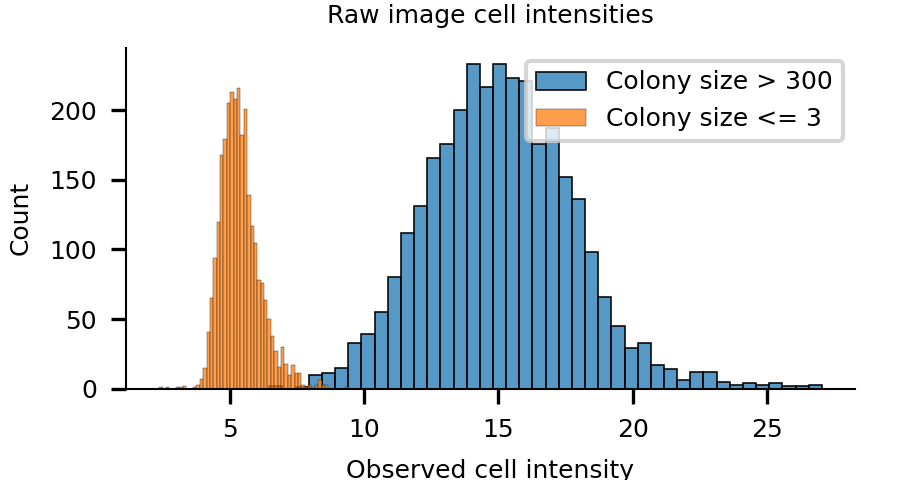

In [23]:
fig, ax = plt.subplots(figsize=(3,1.6), dpi = 300)
fig.subplots_adjust(left=0.14, right=0.95, top = 0.9, bottom = 0.19)
plt.title("Raw image cell intensities")
sns.histplot(data = real_colony_data.query("`Colony N cells` > 300"), x = "Mean Observed intensity", label = "Colony size > 300")
sns.histplot(data = real_colony_data.query("`Colony N cells` <= 3"), x = "Mean Observed intensity", label = "Colony size <= 3")
plt.xlabel("Observed cell intensity")
#plt.xlim(376, 11291)
plt.legend()
plt.savefig("observed_hist.svg")

In [24]:
real_colony_data.query("`Colony N cells` > 300")["Mean Observed intensity"].mean()

15.094884035332091

In [25]:
real_colony_data.query("`Colony N cells` > 300")["Mean Deconvolved intensity real PSF"].mean()

15.360435985426554

In [26]:
real_colony_data.query("`Colony N cells` > 300")["Mean Deconvolved intensity large PSF"].mean()

16.224255043376758

In [27]:
15.1/ 16.22

0.9309494451294699

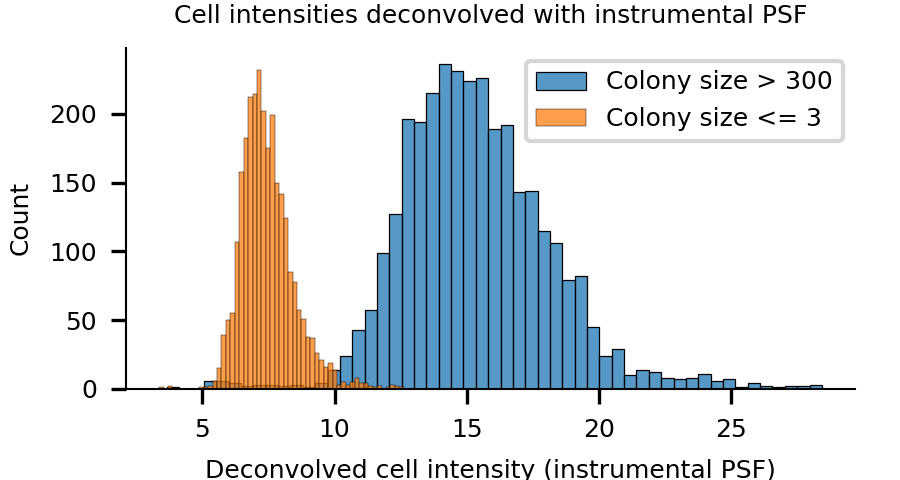

In [28]:
fig, ax = plt.subplots(figsize=(3,1.6), dpi = 300)
fig.subplots_adjust(left=0.14, right=0.95, top = 0.9, bottom = 0.19)
plt.title("Cell intensities deconvolved with instrumental PSF")
sns.histplot(data = real_colony_data.query("`Colony N cells` > 300"), x = "Mean Deconvolved intensity real PSF", label = "Colony size > 300")
sns.histplot(data = real_colony_data.query("`Colony N cells` <= 3"), x = "Mean Deconvolved intensity real PSF", label = "Colony size <= 3")
plt.xlabel("Deconvolved cell intensity (instrumental PSF)")
plt.legend()
#plt.xlim(376, 11291)
plt.savefig("iPSF_deconv_hist.svg")

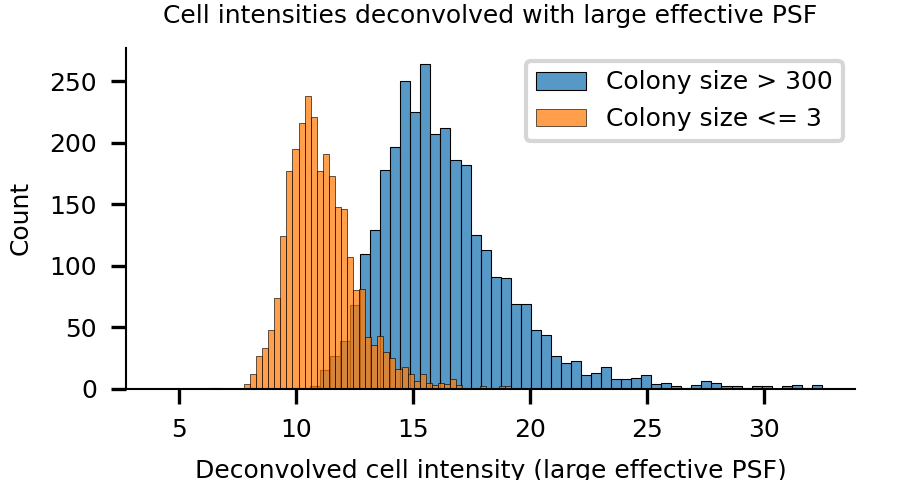

In [29]:
fig, ax = plt.subplots(figsize=(3,1.6), dpi = 300)
fig.subplots_adjust(left=0.14, right=0.95, top = 0.9, bottom = 0.19)
plt.title("Cell intensities deconvolved with large effective PSF")
sns.histplot(data = real_colony_data.query("`Colony N cells` > 300 & `Mean Deconvolved intensity large PSF` > 2000*0.003"), x = "Mean Deconvolved intensity large PSF", label = "Colony size > 300")
sns.histplot(data = real_colony_data.query("`Colony N cells` <= 3"), x = "Mean Deconvolved intensity large PSF", label = "Colony size <= 3")
plt.xlabel("Deconvolved cell intensity (large effective PSF)")
plt.legend()
#.xlim(376, 11291)
plt.savefig("ePSF_deconv_hist.svg")